In [1]:
import scipy 
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n_sequence = 100
sequence_length = 1000
generator = np.random.default_rng(seed=0)

(array([ 2.,  0., 12., 14., 14., 17., 16.,  8.,  9.,  8.]),
 array([-1.16251539, -0.94614422, -0.72977305, -0.51340188, -0.29703072,
        -0.08065955,  0.13571162,  0.35208279,  0.56845396,  0.78482512,
         1.00119629]),
 <BarContainer object of 10 artists>)

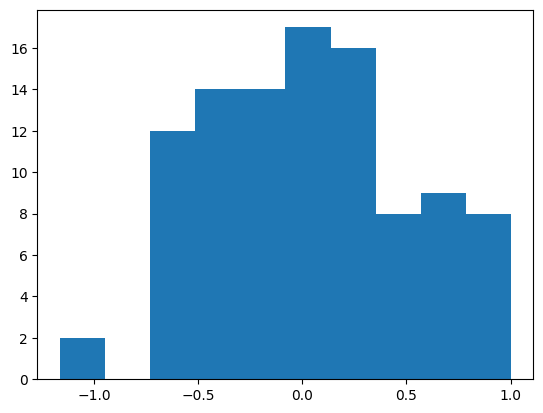

In [3]:
plt.hist(generator.normal(0, 0.5, 100))

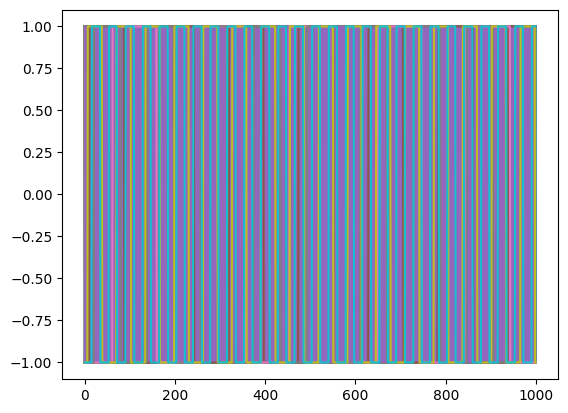

In [4]:
period = np.full(n_sequence, sequence_length/10)
period += 2*(generator.random(n_sequence)-0.5)*period

phase = generator.random(n_sequence)*period
t = np.linspace(phase, sequence_length+phase, sequence_length, endpoint=False).T
control = signal.square(2 * np.pi *((1/period)*t.T).T)

for i in range(n_sequence):
    plt.plot(np.linspace(0, sequence_length, sequence_length, endpoint=False), control[i])

(array([11.,  8.,  9.,  9.,  7., 15.,  5.,  8., 14., 14.]),
 array([  1.28177653,  21.05194584,  40.82211515,  60.59228446,
         80.36245377, 100.13262308, 119.90279239, 139.6729617 ,
        159.44313101, 179.21330032, 198.98346963]),
 <BarContainer object of 10 artists>)

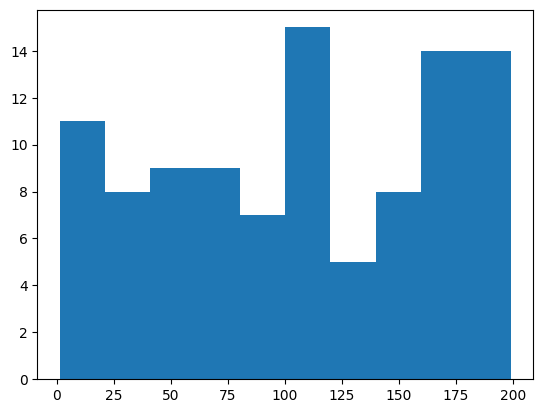

In [5]:
plt.hist(period)

In [ ]:
from world_machine_experiments import  shared
from world_machine_experiments.toy1d import base

from hamilton import driver
import torch


d = driver.Builder().with_modules(base, shared).build()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

inputs = {"sequence_lenght": 1000,
        "n_sequence": 10000,
        "context_size": 200,
        "state_control":"periodic",
        "seed":0
                       }

In [ ]:
outputs = d.execute(["toy1d_data"], inputs=inputs)

In [9]:
outputs["toy1d_data"]["state_decoded"].shape

(10000, 1000, 3)

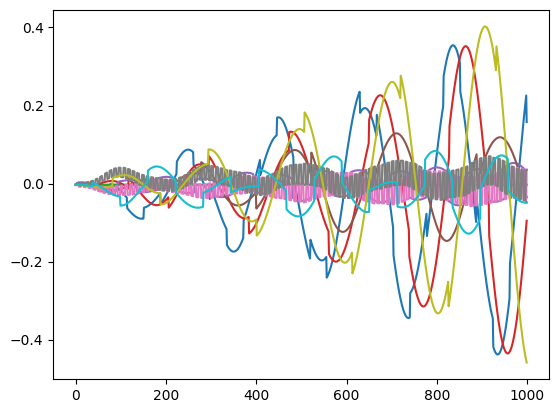

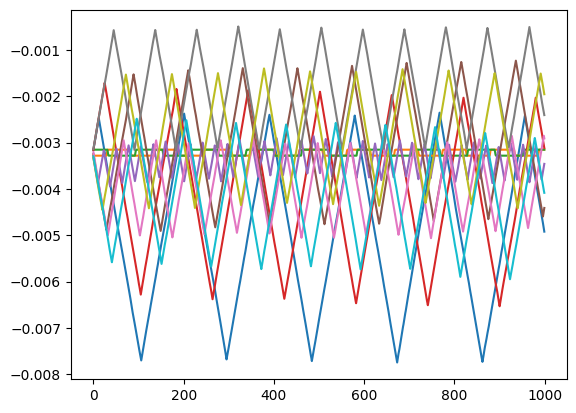

In [10]:
for i in range(10):
    plt.plot(outputs["toy1d_data"]["state_decoded"][i,:,0])
plt.show()



for i in range(10):
    plt.plot(outputs["toy1d_data"]["state_decoded"][i,:,2])
plt.show()


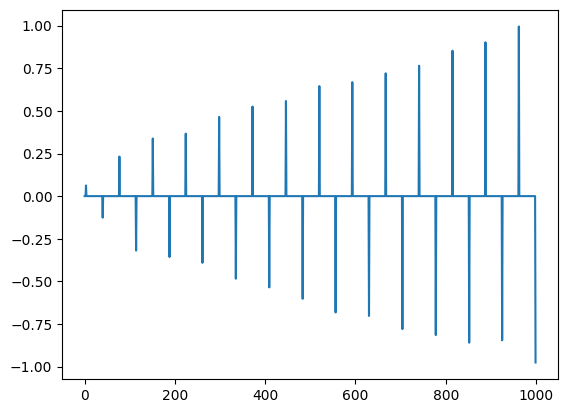

In [11]:
plt.plot(outputs["toy1d_data"]["state_control"][0,:,0])

In [12]:
period = np.full(n_sequence, sequence_length/10)
period += 3*(generator.random(n_sequence)-0.5)*period

phase = generator.random(n_sequence)*period
t = np.linspace(phase, sequence_length+phase,
            sequence_length, endpoint=False).T
control_pulse = signal.square(2 * np.pi * ((1/period)*t.T).T)
control_pulse = (control_pulse-np.roll(control_pulse, 1, 1))/2

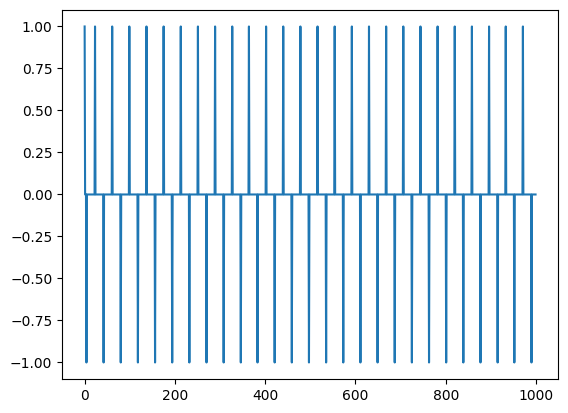

In [13]:
plt.plot(control_pulse[0])

## Eval model

In [1]:
import scipy 
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from hamilton import driver
import torch
from tensordict import TensorDict

from world_machine_experiments import  shared
from world_machine_experiments.toy1d import base


In [2]:
d = driver.Builder().with_modules(base, shared).build()

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [4]:


inputs = {"sequence_lenght": 1000,
            "n_sequence": 10000,
            "context_size": 200,
            "state_dimensions": None,
            "batch_size": 32,
            "device": device,
            "seed":[0, 42],
            "state_control": "periodic",
        }

In [5]:
outputs = d.execute(["toy1d_data", "toy1d_dataloaders"], inputs=inputs)

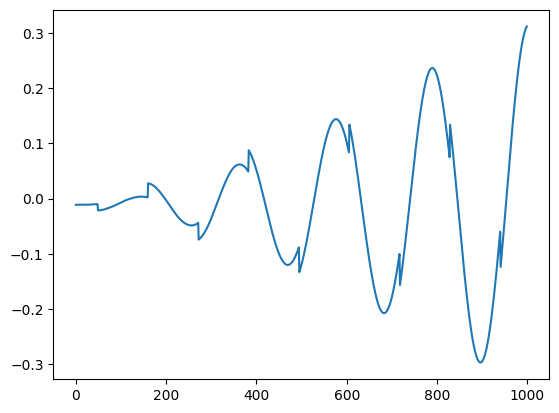

In [46]:
plt.plot(outputs["toy1d_data"]["state_decoded"][3,:,0])

In [48]:
item = next(iter(outputs["toy1d_dataloaders"]["train"]))

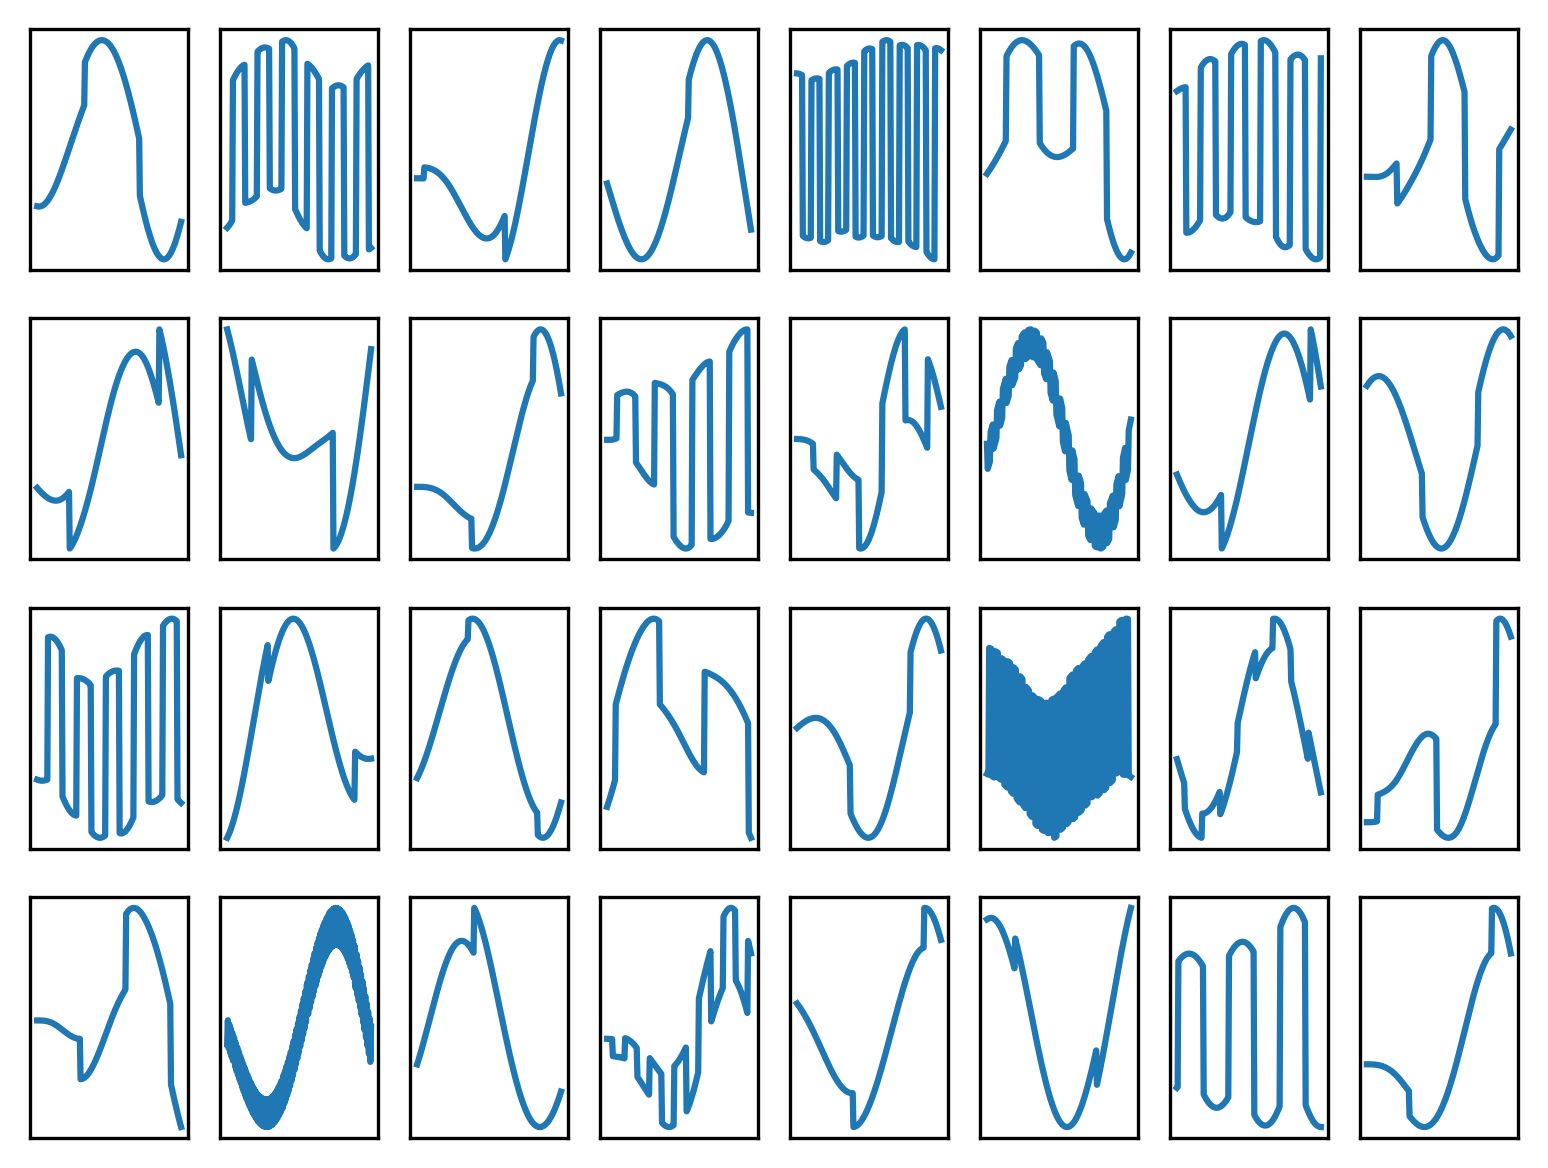

In [51]:
axis = 0
fig, axs = plt.subplots(4, 8, dpi=300)

for i in range(32):
    row = i // 8
    column = i % 8

    axs[row, column].plot(item["targets"]["state_decoded"][i,:,0])


    axs[row, column].set_xticks([])
    axs[row, column].set_yticks([])

plt.show()

In [160]:
models = {}

models["Base"] = torch.load("toy1d_memory\\Base\\run_0\\toy1d_model.pt")
models["M0-90"] = torch.load("toy1d_memory\\M0-90\\run_0\\toy1d_model.pt")
models["NoDiscover_M0-90"] = torch.load("toy1d_memory\\NoDiscover_M0-90\\run_0\\toy1d_model.pt")
models["NoDiscover_M0-90_NoDecoded"] = models["NoDiscover_M0-90"]

for name in models:
    models[name].eval()
    models[name].to(device)

torch.set_grad_enabled(False)

C:\Users\eltsu\AppData\Local\Temp\ipykernel_58480\2222764236.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  models["Base"] = torch.load("toy1d_memory\\Base\\run_0\\toy1

In [161]:
inputs: torch.Tensor = item["inputs"].to(device)
targets: torch.Tensor = item["targets"]["state_decoded"].to(
    device)

if "state_decoded" in inputs:
    batch_size = inputs["state_decoded"].shape[0]
    seq_len = inputs["state_decoded"].shape[1]

state_size = models["Base"]._state_size

state = torch.rand(
    (batch_size, seq_len, state_size), device=device)
state = (2*state)-1

state = {name:state for name in models}

sensorial_masks = None

for i in range(seq_len):
    logits = {}
    for name in models:
        
        if name == "NoDiscover_M0-90":
            state_decoded = inputs["state_decoded"]
        else:
            state_decoded = None

        logits[name] = models[name](
            state=state[name], 
            state_decoded=state_decoded,
            sensorial_data=inputs, sensorial_masks=sensorial_masks)

        if i != seq_len-1:
            state[name][:, i+1] = logits[name]["state"][:, i]

In [162]:
logits = {name:logits[name].cpu() for name in logits}

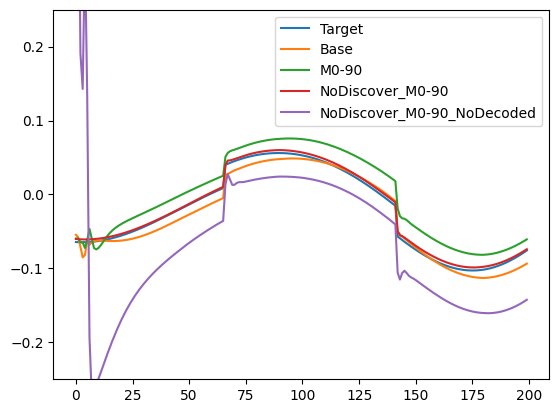

In [165]:
plt.plot(item["targets"]["state_decoded"][0,:,0], label="Target")
for name in logits:
    plt.plot(logits[name]["state_decoded"][0,:,0], label=name)

plt.ylim(-0.25, 0.25)
plt.legend()

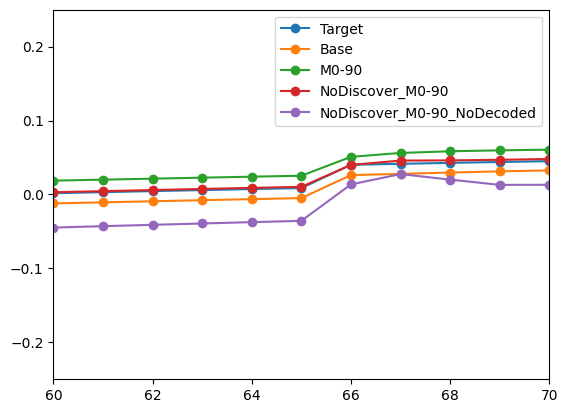

In [166]:
plt.plot(item["targets"]["state_decoded"][0,:,0], "o-", label="Target")
for name in logits:
    plt.plot(logits[name]["state_decoded"][0,:,0], "o-", label=name)

plt.xlim(60,70)
plt.ylim(-0.25, 0.25)
plt.legend()

In [ ]:
plt.plot(item["targets"]["state_decoded"][0,:,0], "o-")
plt.plot(logits["Base"]["state_decoded"][0,:,0], "o-")

plt.xlim(60,70)

In [78]:
logits["Base"]["state_decoded"][0,:,0][:10], logits["M0-90"]["state_decoded"][0,:,0][:10]

(tensor([-0.0523, -0.0698, -0.0761, -0.0792, -0.0815, -0.0828, -0.0832, -0.0833,
         -0.0833, -0.0832]),
 tensor([-0.0523, -0.0366, -0.0314, -0.0334, -0.0399, -0.0441, -0.0438, -0.0424,
         -0.0414, -0.0408]))

In [173]:
state_half = {name:state[name][:, 100:].clone() for name in state}

sensorial_masks = None

inputs_half = {}

for name in inputs.keys():
    inputs_half[name] = inputs[name][:, 100:].clone()

inputs_half = TensorDict(inputs_half)

for i in range(100):
    logits_half = {}
    for name in models:
        if name == "NoDiscover_M0-90":
            state_decoded = inputs["state_decoded"]
        else:
            state_decoded = None

        logits_half[name] = models[name](
            state=state_half[name],
            state_decoded=state_decoded,
            sensorial_data=inputs_half, sensorial_masks=sensorial_masks, input_sequence_size=100)

        if i != 100-1:
            state_half[name][:, i+1] = logits_half[name]["state"][:, i]

logits_half = {name:logits_half[name].cpu() for name in logits_half}

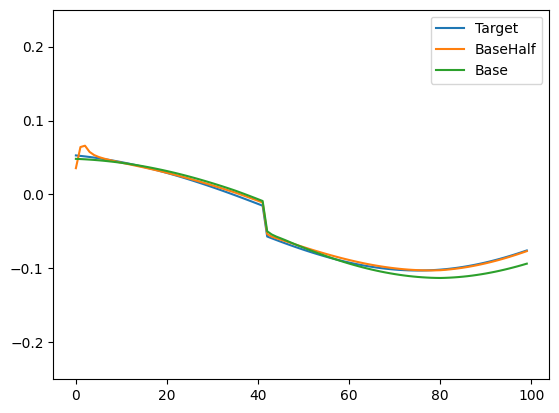

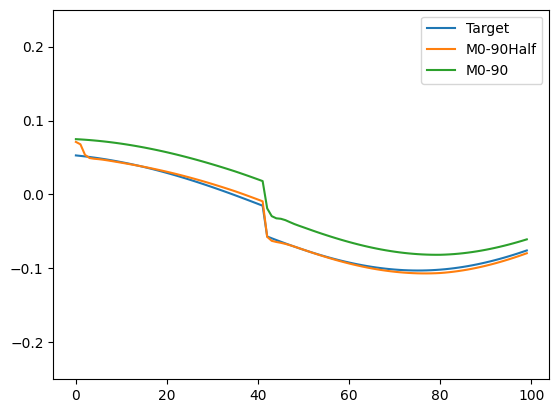

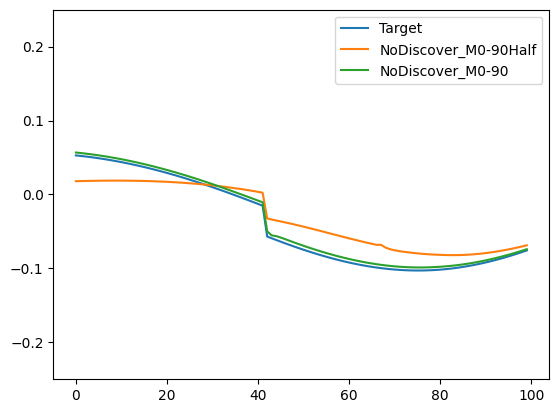

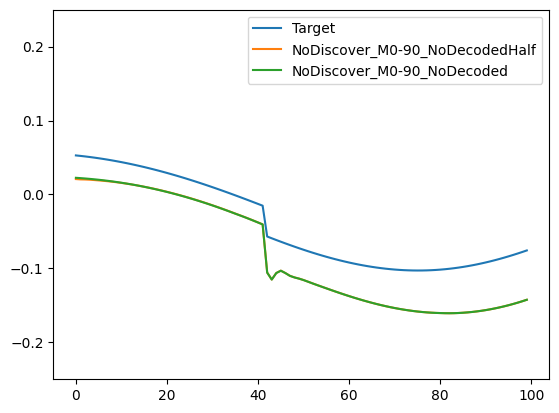

In [174]:
for name in logits:

    plt.plot(item["targets"]["state_decoded"][0,100:,0], label="Target")

    plt.plot(logits_half[name]["state_decoded"][0,:,0], label=name+"Half")

    plt.plot(logits[name]["state_decoded"][0,100:,0], label=name)

    plt.ylim(-0.25, 0.25)

    plt.legend()

    plt.show()


In [170]:
sensorial_masks_masked = TensorDict(
                        device=device, batch_size=batch_size)

sensorial_data: TensorDict = inputs
for name in sensorial_data.keys():
    sensorial_masks_masked[name] = torch.zeros(
        (batch_size, 100), dtype=bool, device=device)

In [175]:
state_half_masked = {name:state[name][:, 100:].clone() for name in state}

inputs_half_masked = {}

for name in inputs.keys():
    inputs_half_masked[name] = inputs[name][:, 100:].clone()

inputs_half_masked = TensorDict(inputs_half_masked)

for i in range(100):
    logits_half_masked = {}
    for name in models:
        if name == "NoDiscover_M0-90":
            state_decoded = inputs["state_decoded"]
        else:
            state_decoded = None


        logits_half_masked[name] = models[name](
            state=state_half_masked[name],
            state_decoded=state_decoded,
            sensorial_data=inputs_half_masked, sensorial_masks=sensorial_masks_masked, input_sequence_size=100)

        if i != 100-1:
            state_half_masked[name][:, i+1] = logits_half_masked[name]["state"][:, i]

logits_half_masked = {name:logits_half_masked[name].cpu() for name in logits_half_masked}

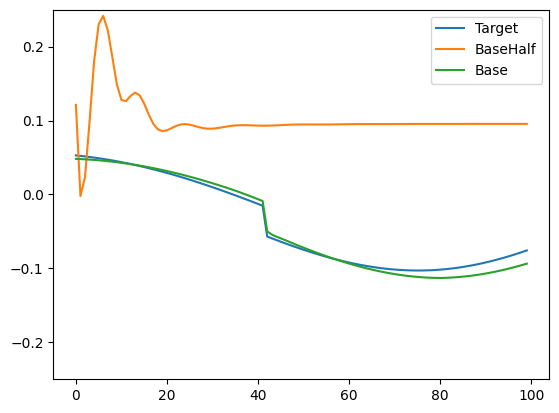

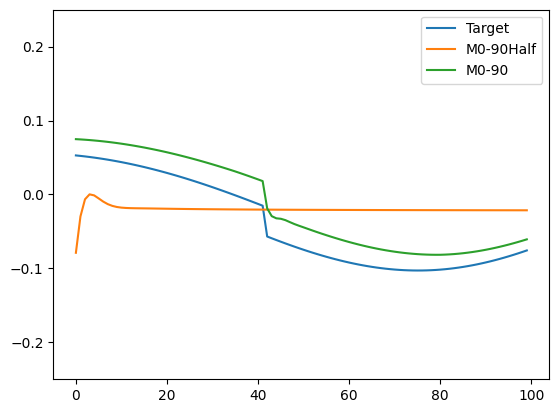

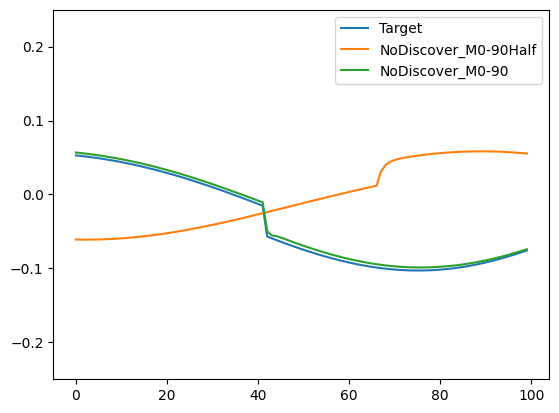

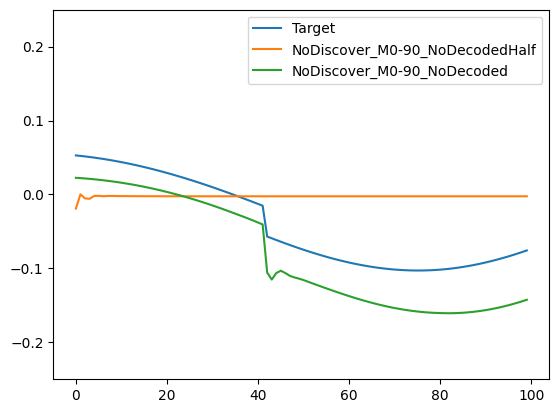

In [176]:
for name in logits:

    plt.plot(item["targets"]["state_decoded"][0,100:,0], label="Target")

    plt.plot(logits_half_masked[name]["state_decoded"][0,:,0], label=name+"Half")

    plt.plot(logits[name]["state_decoded"][0,100:,0], label=name)

    plt.legend()
    plt.ylim(-0.25, 0.25)

    plt.show()


In [8]:
item

TensorDict(
    fields={
        index: Tensor(shape=torch.Size([32]), device=cpu, dtype=torch.int64, is_shared=False),
        inputs: TensorDict(
            fields={
                next_measurement: Tensor(shape=torch.Size([32, 200, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                state_control: Tensor(shape=torch.Size([32, 200, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                state_decoded: Tensor(shape=torch.Size([32, 200, 3]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([32, 200]),
            device=None,
            is_shared=False),
        targets: TensorDict(
            fields={
                next_measurement: Tensor(shape=torch.Size([32, 200, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                state_control: Tensor(shape=torch.Size([32, 200, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                state_decoded: Tensor(shape=torch.Size([32, 200, 3])

In [9]:
generator = np.random.default_rng(0)

In [12]:
seq_len = item["inputs"][next(
                iter(item["inputs"].keys()))].shape[1]

In [16]:
item

TensorDict(
    fields={
        inputs: TensorDict(
            fields={
                next_measurement: Tensor(shape=torch.Size([32, 200, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                state_control: Tensor(shape=torch.Size([32, 200, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                state_decoded: Tensor(shape=torch.Size([32, 200, 3]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([32, 200]),
            device=None,
            is_shared=False),
        targets: TensorDict(
            fields={
                next_measurement: Tensor(shape=torch.Size([32, 200, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                state_control: Tensor(shape=torch.Size([32, 200, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                state_decoded: Tensor(shape=torch.Size([32, 200, 3]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([32, 20

In [19]:
batch_size = 32

In [24]:
%timeit item.clone()

108 μs ± 7.53 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [25]:
item = next(iter(outputs["toy1d_dataloaders"]["train"]))

def test():
    index = item["index"]
    del item["index"]
    item["index"] = index

%timeit test()

13.1 μs ± 485 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [27]:
break_index = int(generator.uniform(0, seq_len))

item = next(iter(outputs["toy1d_dataloaders"]["train"]))
index = item["index"]
del item["index"]

item.batch_size = [batch_size, seq_len]

item_parts = []

for slice in ["start", "end"]:
    part = {}

    if slice == "start":
        part = item[:, :break_index]
    else:
        part = item[:, break_index:]

    part.batch_size = [batch_size]

    part["index"] = index
    item_parts.append(part)

item.batch_size = [batch_size]
item["index"] = index

item_parts[0]

TensorDict(
    fields={
        index: Tensor(shape=torch.Size([32]), device=cpu, dtype=torch.int64, is_shared=False),
        inputs: TensorDict(
            fields={
                next_measurement: Tensor(shape=torch.Size([32, 108, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                state_control: Tensor(shape=torch.Size([32, 108, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                state_decoded: Tensor(shape=torch.Size([32, 108, 3]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([32, 108]),
            device=None,
            is_shared=False),
        targets: TensorDict(
            fields={
                next_measurement: Tensor(shape=torch.Size([32, 108, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                state_control: Tensor(shape=torch.Size([32, 108, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                state_decoded: Tensor(shape=torch.Size([32, 108, 3])

In [ ]:
for part in item_parts:
    del part["index"]
    seq_len = part["inputs"][next(
            iter(part["inputs"].keys()))].shape[1]
    part.batch_size = [batch_size, seq_len]

In [63]:
part.batch_size[0]

32

In [51]:
import tensordict

reconstructed_item = tensordict.cat(item_parts, dim=1)
reconstructed_item.batch_size = [batch_size]
reconstructed_item["index"] = index

In [56]:
(reconstructed_item != item).sum()["inputs"]["state_decoded"]

tensor(0)

In [200]:
inputs_test = item_parts[0]["inputs"].to(device)



logits_test = models["Base"](
            state=state["Base"][:,:break_index],  # state.clone(),
            sensorial_data=inputs_test, sensorial_masks=None, input_sequence_size=break_index)

In [177]:
a = [1,2,3]
b = [4,5,6]

a.clear()
a.extend(b)

a

[4, 5, 6]

In [192]:
item_recreate = item_parts[0].clone()

for part in item_parts[1:]:
    for dim in ["inputs", "targets"]:
        for name in item[dim].keys():
            if name == "masks":
                continue

            item_recreate[dim][name] = torch.concat((item_recreate[dim][name], part[dim][name]), dim=1)

        if "masks" in item[dim]:
            for name in item[dim].keys():
                item_recreate[dim]["masks"][name] = torch.concat((item_recreate[dim]["masks"][name], part[dim]["masks"][name]), dim=1)

In [193]:
(item_recreate["inputs"]["state_decoded"] != item["inputs"]["state_decoded"]).sum()

tensor(0)

In [1]:
from tensordict import TensorDict
import torch

In [3]:
x = torch.empty([32, 200, 6])
x_dict = TensorDict({"x1":x, "x2":x})

In [5]:
x_dict.batch_size = [32,200]

In [8]:
x_dict[0,0]

TensorDict(
    fields={
        x1: Tensor(shape=torch.Size([6]), device=cpu, dtype=torch.float32, is_shared=False),
        x2: Tensor(shape=torch.Size([6]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)

In [6]:
item = next(iter(outputs["toy1d_dataloaders"]["train"]))

In [7]:
item

TensorDict(
    fields={
        index: Tensor(shape=torch.Size([32]), device=cpu, dtype=torch.int64, is_shared=False),
        inputs: TensorDict(
            fields={
                next_measurement: Tensor(shape=torch.Size([32, 200, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                state_control: Tensor(shape=torch.Size([32, 200, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                state_decoded: Tensor(shape=torch.Size([32, 200, 3]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([32, 200]),
            device=None,
            is_shared=False),
        targets: TensorDict(
            fields={
                next_measurement: Tensor(shape=torch.Size([32, 200, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                state_control: Tensor(shape=torch.Size([32, 200, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                state_decoded: Tensor(shape=torch.Size([32, 200, 3])

In [11]:
item["inputs"][next(iter(item["inputs"].keys()))].shape

torch.Size([32, 200, 2])

In [13]:
item["inputs_masks"] = TensorDict()

In [14]:
item["inputs_masks"]["a"] = torch.empty(32, 200)

In [1]:
class A:
    def __init__(self, num):
        self.num = num

In [2]:
my_list = [A(0), A(2), A(-1), A(3)]

my_list.sort(key= lambda a: a.num)

In [4]:
[a.num for a in my_list]

[-1, 0, 2, 3]

In [12]:
state = torch.Generator().get_state()

In [17]:
state_cuda = torch.Generator(device="cuda").get_state()

In [18]:
state.shape, state_cuda.shape

(torch.Size([5056]), torch.Size([16]))